In [1]:
from tensorflow import keras


In [2]:
from __future__ import print_function
import random, numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.utils import image_dataset_from_directory
from keras.layers import Dense, Dropout, Activation, Flatten, Rescaling, RandomRotation, RandomFlip, RandomCrop, RandomTranslation, RandomZoom
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import *

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
import keras, tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Set random seed

#### กำหนด random seed

In [4]:
import random, os, tensorflow as tf

def set_seed(seed_value=12345):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # to Disable GPU training

In [5]:
import tensorflow as tf
tf.__version__

'2.10.1'

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18161624660699618854
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1802502144
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12883334165653490134
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [7]:
print('Default GPU Device:', tf.test.gpu_device_name() or 'None')

Default GPU Device: /device:GPU:0


In [8]:
data = './KanjiN5_dataset/'

## Model Finetuning

In [9]:
num_classes = 81
batch_size = 64
image_size = 120

#### ทำ image augmentation โดยใช้ ImageDataGenerator

In [10]:
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
                                                height_shift_range=0.1,
                                                width_shift_range=0.1,
                                                zoom_range=0.1,
) 

#### นำข้อมูลเข้าจาก Train, Validation, Test จาก datasets โดยใช้ flow_from_directory กำหนดขนาดภาพที่ขนาด 120 x 120

In [11]:
#https://stackoverflow.com/questions/60927259/keras-flow-from-directory-shuffle-not-working-properly
train_ds = data_augmentation.flow_from_directory(
    directory=os.path.join(data, "Train"),
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=True
)

valid_ds = data_augmentation.flow_from_directory(
directory=os.path.join(data, "Valid"),
class_mode='categorical',
batch_size=batch_size,
target_size=(image_size, image_size),
shuffle=False
)

test_ds = data_augmentation.flow_from_directory(
    directory=os.path.join(data, "Test"),
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 9071 images belonging to 81 classes.
Found 2592 images belonging to 81 classes.
Found 1377 images belonging to 81 classes.


In [12]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D


#### import VGG16 model จาก keras.applications  เพื่อทำการ fine-tune model
#### - กำหนด Dropout ที่ 0.5 และใช้ Output layer เป็น softmax activation function

In [19]:
base_model = VGG16(weights='imagenet', include_top=False, 
                   input_shape=(image_size, image_size, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
#  i.e. freeze all convolutional InceptionV3 layers
# for layer in base_model.layers[:-2]:
#     layer.trainable = False
    
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 120, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 120, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 60, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 60, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 60, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 30, 30, 128)       0   

#### ทำการ freeze model  แล้วเทรนโครงสร้าง

In [20]:
epochs = 3
model.fit(train_ds, epochs=epochs, validation_data=valid_ds) 
#add augmentation flow from a directory path

Epoch 1/3
142/142 [==============================] - 33s 227ms/step - loss: 2.7400 - accuracy: 0.4832 - val_loss: 0.7873 - val_accuracy: 0.7901
Epoch 2/3
142/142 [==============================] - 32s 227ms/step - loss: 0.8791 - accuracy: 0.7517 - val_loss: 0.5752 - val_accuracy: 0.8380
Epoch 3/3
142/142 [==============================] - 31s 220ms/step - loss: 0.6427 - accuracy: 0.8130 - val_loss: 0.5506 - val_accuracy: 0.8507


In [21]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


#### ทำการ unfreezing model เพื่อเทรนกับข้อมูลที่เราต้องการจะทำการ fine tune

In [22]:
#https://stackoverflow.com/questions/64227483/what-is-the-right-way-to-gradually-unfreeze-layers-in-neural-network-while-learn
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
base_model.trainable = True
for layer in model.layers[:15]:
    layer.trainable = False
    print(layer)
# for layer in model.layers[15:]:
#    layer.trainable = True
#    print(layer)

In [17]:
os.mkdir('new_labels_weight')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'new_labels_weight'

#### กำหนด callbacks โดยใช้ EarlyStopping
##### - monitering เพื่อที่จะ break จาก validation_accuracy
##### -  เก็บ best model ที่ filepath

In [23]:
filepath = "./new_labels_weight/save-{epoch:02d}-{loss:.4f}.h5"
callback = [EarlyStopping(patience=3, monitor='val_accuracy'), 
        ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')]

In [24]:
set_seed(12345)
#https://datascience.stackexchange.com/questions/73093/what-does-from-logits-true-do-in-sparsecategoricalcrossentropy-loss-function
epochs = 20

from keras.optimizers import SGD
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-6), loss=keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
# when using sigmoid on last Dense we need to set from_logits=False

# alongside the top Dense layers
history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=callback)

Epoch 1/20
142/142 [==============================] - ETA: 0s - loss: 0.4604 - accuracy: 0.8582
Epoch 1: val_accuracy improved from -inf to 0.88349, saving model to ./new_labels_weight\save-01-0.4604.h5
142/142 [==============================] - 32s 223ms/step - loss: 0.4604 - accuracy: 0.8582 - val_loss: 0.3834 - val_accuracy: 0.8835
Epoch 2/20
142/142 [==============================] - ETA: 0s - loss: 0.3832 - accuracy: 0.8815
Epoch 2: val_accuracy improved from 0.88349 to 0.90046, saving model to ./new_labels_weight\save-02-0.3832.h5
142/142 [==============================] - 34s 236ms/step - loss: 0.3832 - accuracy: 0.8815 - val_loss: 0.3501 - val_accuracy: 0.9005
Epoch 3/20
142/142 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.9042
Epoch 3: val_accuracy improved from 0.90046 to 0.90394, saving model to ./new_labels_weight\save-03-0.3223.h5
142/142 [==============================] - 35s 247ms/step - loss: 0.3223 - accuracy: 0.9042 - val_loss: 0.3047 - val_

## Loss visualization 

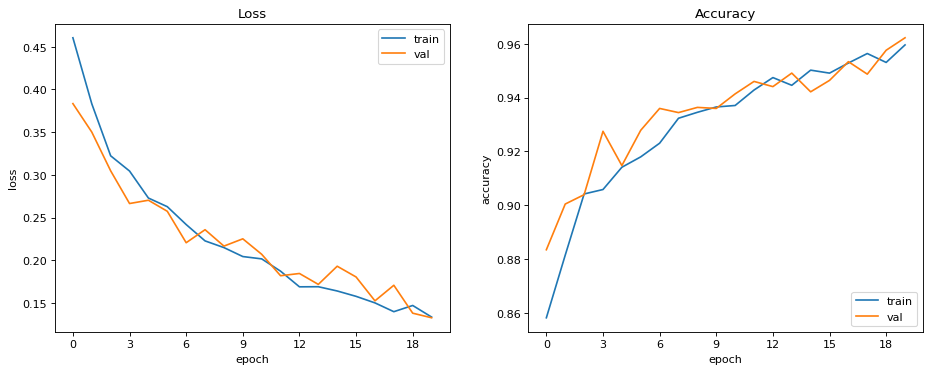

In [25]:
# Loss accuracy
fig = plt.figure(figsize=(14, 5), dpi=80)
ax = fig.add_subplot(1, 2, 1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper right')

ax = fig.add_subplot(1, 2, 2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history.history['accuracy'])

ax.plot(history.history['val_accuracy'])
ax.set_title('Accuracy')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='lower right')

In [26]:
print('Train Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(train_ds, verbose=0)))
print('Validation Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(valid_ds, verbose=0)))
print('Test Loss: {:.6f}, Accuracy: {:.6f}'.format(*model.evaluate(test_ds, verbose=0)))



Train Loss: 0.056786, Accuracy: 0.982472
Validation Loss: 0.163081, Accuracy: 0.952546
Test Loss: 0.050809, Accuracy: 0.983297


In [27]:
test_ds.classes[:10], test_ds.classes[-10:]

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([80, 80, 80, 80, 80, 80, 80, 80, 80, 80]))

In [28]:
# Generate predictions
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_ds.classes



22/22 [==============================] - 4s 163ms/step


In [29]:
len(true_labels)

1377

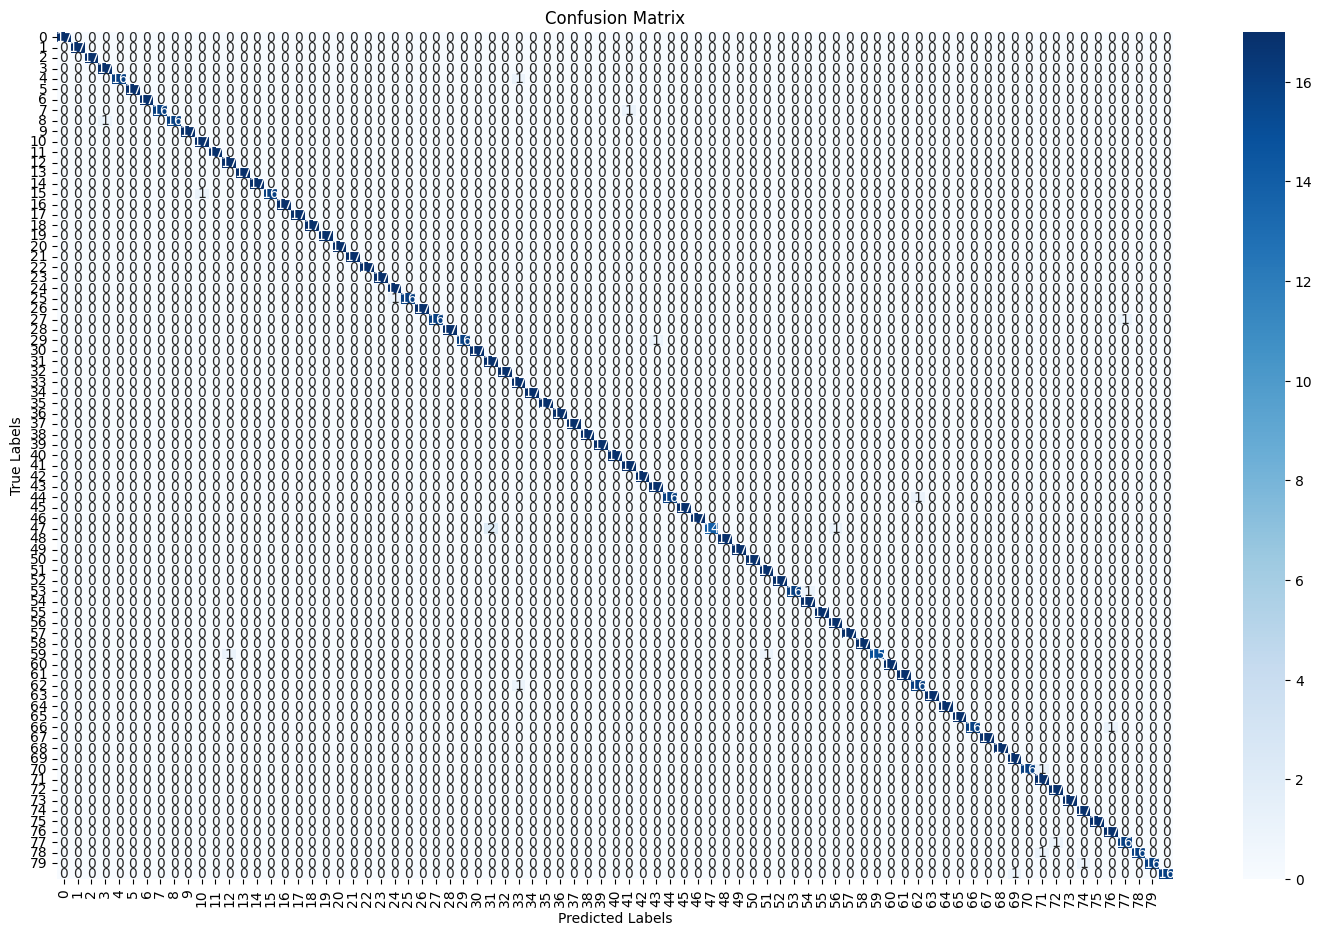

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(true_labels, y_pred)
# Define class labels (assuming your classes are named '0', '1', ..., '19')
class_names = [i for i in range(80)]

# Plot confusion matrix
plt.figure(figsize=(18, 11))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [31]:

from sklearn.metrics import classification_report
 

In [32]:
# Generate classification report
report = classification_report(true_labels, y_pred, target_names=list(train_ds.class_indices.keys()))
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           一       1.00      1.00      1.00        17
           七       1.00      1.00      1.00        17
           万       1.00      1.00      1.00        17
           三       0.94      1.00      0.97        17
           上       1.00      0.94      0.97        17
           下       1.00      1.00      1.00        17
           中       1.00      1.00      1.00        17
           九       1.00      0.94      0.97        17
           二       1.00      0.94      0.97        17
           五       1.00      1.00      1.00        17
           人       0.94      1.00      0.97        17
           今       1.00      1.00      1.00        17
           休       0.94      1.00      0.97        17
           何       1.00      1.00      1.00        17
           先       1.00      1.00      1.00        17
           入       1.00      0.94      0.97        17
           八       1.00      1.00      1.00        17
    

In [90]:
#load a model
# from keras.models import load_model
# from keras.preprocessing import image
# import numpy as np

# Load the saved model
# model = load_model("./Indiannet_weight/save-14-0.1555.h5")

# class_name = ['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa']

# # Load and preprocess the image
# img_path = "./Indiannet_weight/save-14-0.1555.h5"
# img = image.load_img(img_path, target_size=(256, 256))  # adjust target_size as needed
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.  # Normalize the image data

# # Make predictions
# predictions = model.predict(img_array)
# accuracy_percent = np.max(predictions) * 100

# # Print the predicted class
# predicted_class = np.argmax(predictions)
# print(f"Predicted class: {class_name[predicted_class]} [{predicted_class}]")
# print(f"with accuracy {accuracy_percent:.2f} %")


In [33]:
model.save('vgg16_unfreeze3.h5')